## Backtesting Trading Strategies

Let's take the Golden and Death cross example from the technical analysis file and simulate a simple trading strategy where we buy on the Golden Cross and sell on the Death Cross. For simplicity, we will only simulate long positions (no short selling).

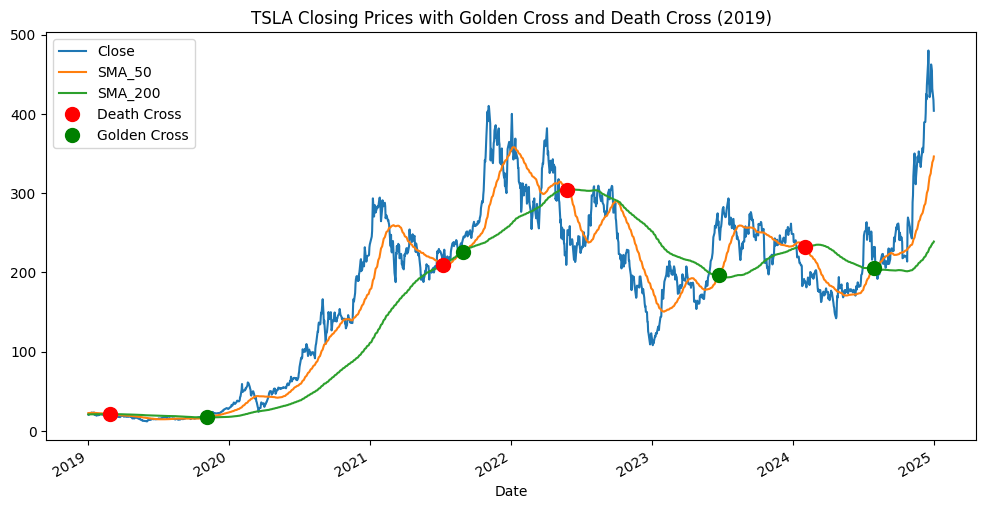

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf

tesla_df = yf.Ticker("TSLA").history(period="max")

tesla_df['SMA_50'] = tesla_df['Close'].rolling(window=50).mean()
tesla_df['SMA_200'] = tesla_df['Close'].rolling(window=200).mean()

tesla_df['Signal'] = 0
tesla_df.loc[tesla_df['SMA_50'] > tesla_df['SMA_200'], 'Signal'] = 1
tesla_df.loc[tesla_df['SMA_50'] < tesla_df['SMA_200'], 'Signal'] = -1

tesla_df['Crossover'] = tesla_df['Signal'].diff()

tesla_df_small = tesla_df.loc['2019':'2024']

fig, ax = plt.subplots(figsize=(12, 6))
tesla_df_small[['Close', 'SMA_50', 'SMA_200']].plot(ax=ax, title="TSLA Closing Prices with Golden Cross and Death Cross (2019)")

crosses = tesla_df_small[tesla_df_small['Crossover'] != 0]
for idx, row in crosses.iterrows():
    if row['Crossover'] == 2:
        plt.plot(idx, row['SMA_50'], 'go', markersize=10, label='Golden Cross' if 'Golden Cross' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    elif row['Crossover'] == -2:
        plt.plot(idx, row['SMA_50'], 'ro', markersize=10, label='Death Cross' if 'Death Cross' not in [text.get_text() for text in ax.get_legend().get_texts()] else "")
    plt.legend()

plt.show()

In [2]:
initial_capital = 10000
end_capital = initial_capital
buy_price = 0

for idx, row in crosses.iterrows():
    # Simulating buying on Golden Cross
    if row['Crossover'] == 2:
        buy_price = row['Close']
        print(f'Bought at: ${buy_price:.2f}.')

    # Simulating selling on Death Cross
    elif row['Crossover'] == -2 and buy_price != 0:
        sell_price = row['Close']
        gain_pct = (sell_price-buy_price) / buy_price
        print(f'Sold at: ${sell_price:.2f}. Gained {gain_pct*100:.2f}%.')
        end_capital = (1+gain_pct) * end_capital

# Calculating total gain percentage
total_pct_gain = (end_capital-initial_capital) / initial_capital

print(f'Initial: ${initial_capital}. Ended with: ${end_capital:.2f}. Gained: {total_pct_gain*100:.2f}%.') 

Bought at: $21.15.
Sold at: $218.98. Gained 935.48%.
Bought at: $243.64.
Sold at: $235.91. Gained -3.17%.
Bought at: $256.60.
Sold at: $188.86. Gained -26.40%.
Bought at: $232.10.
Initial: $10000. Ended with: $73795.31. Gained: 637.95%.
